# 😺🐶 CATDOG CLASSIFICATION CNN 😺🐶

File in path has to be unzipped for python to read it.

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

# Set your base directory (update this to your extracted dataset location)
base_dir = r"C:\Users\dr85r\OneDrive\Documents\Deep Learning AZ Files\Deep-Learning-AZ\Deep Learning A-Z\Part 2 - Convolutional Neural Networks (CNN)\dataset"

# Define paths to the training and test sets
train_dir = os.path.join(base_dir, "training_set")
test_dir = os.path.join(base_dir, "test_set")


In [2]:
tf.__version__

'2.10.0'

## Load Raw Datasets

In [3]:
# Define image size and batch size
img_size = (180, 180)
batch_size = 32

# Load raw training dataset with a validation split (80% training, 20% validation)
raw_train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

raw_val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Load raw test dataset (untouched for final evaluation)
raw_test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # No shuffling needed for test set
)

# Extract class names from the training dataset (e.g., ['cats', 'dogs']) -- inferred from filepath
class_names = raw_train_ds.class_names
print("Class names:", class_names)


Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.
Found 2000 files belonging to 2 classes.
Class names: ['cats', 'dogs']


## Set up the validation set - NO AUGMENTATION

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

# For validation and test datasets, cache and prefetch (no augmentation)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Create Augmentation Pipeline and Apply to Training Data
This helps avoid overfitting and improves overall accuracy of the model. In this implementation rescaling is done in the model itself so it can benefit from GPU acceleration. 

In [5]:
# Define your augmentation pipeline (tweak parameters as needed)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Augmentation function applied on each image-label pair
def augment(image, label):
    # Note: augmentation should be applied on images in float format.
    return data_augmentation(image), label

# Cache the raw training images first, then apply augmentation on the fly
cached_train_ds = raw_train_ds.cache()
train_ds = cached_train_ds.map(augment, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)


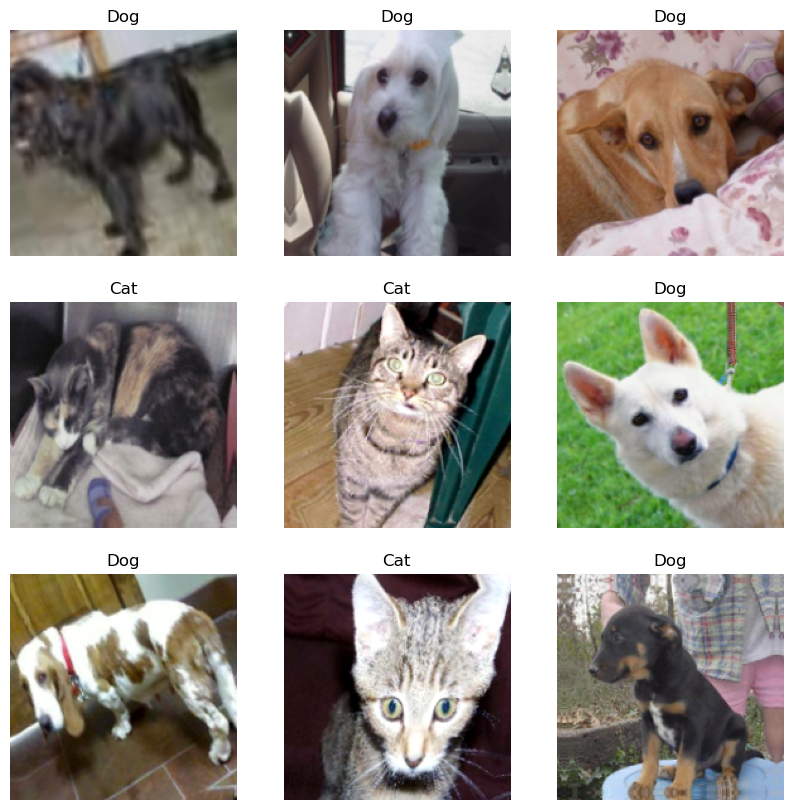

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch
    for i in range(9):  # Show first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # If labels are tensors, use labels[i].numpy()
        plt.title("Cat" if labels[i] == 0 else "Dog")
        plt.axis("off")
plt.show()


Verify data loading. Always a good idea to visualize some of your data first to make sure it's going to load properly...

## 🤖 Define the CNN Model 

In [7]:
model = keras.Sequential([
    keras.layers.Input(shape=(180, 180, 3)),  # Explicit input layer
    layers.Rescaling(1./255),  # Normalize pixel values

    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 90, 90, 64)      

### Compile the Model and Setup Callbacks

In [8]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]


### 🏋️ Train the Model 

In [9]:
epochs = 25  # Adjust as needed
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/25
200/200 [==============================] - 107s 524ms/step - loss: 1.2057 - accuracy: 0.5683 - val_loss: 8.9739 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/25
200/200 [==============================] - 95s 470ms/step - loss: 0.6560 - accuracy: 0.6031 - val_loss: 1.4267 - val_accuracy: 0.5738 - lr: 0.0010
Epoch 3/25
200/200 [==============================] - 92s 457ms/step - loss: 0.6406 - accuracy: 0.6378 - val_loss: 0.8263 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 4/25
200/200 [==============================] - 90s 445ms/step - loss: 0.6287 - accuracy: 0.6330 - val_loss: 0.6727 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 5/25
200/200 [==============================] - 90s 448ms/step - loss: 0.6264 - accuracy: 0.6447 - val_loss: 0.7329 - val_accuracy: 0.5587 - lr: 0.0010
Epoch 6/25
200/200 [==============================] - 93s 461ms/step - loss: 0.6001 - accuracy: 0.6653 - val_loss: 0.5680 - val_accuracy: 0.7237 - lr: 0.0010
Epoch 7/25
200/200 [==============================]

## Evaluate Model

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


63/63 [==============================] - 7s 108ms/step - loss: 0.4396 - accuracy: 0.8005
Test Accuracy: 0.8005


# 🧙‍♂️ Some Example Predictions From Our Test Data...

1/1 [==============================] - 0s 311ms/step


C:\Users\dr85r\AppData\Local\Temp\ipykernel_18368\3505598007.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_names[int(predictions[i] > 0.5)]
C:\Users\dr85r\miniconda3\envs\tn_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dr85r\miniconda3\envs\tn_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


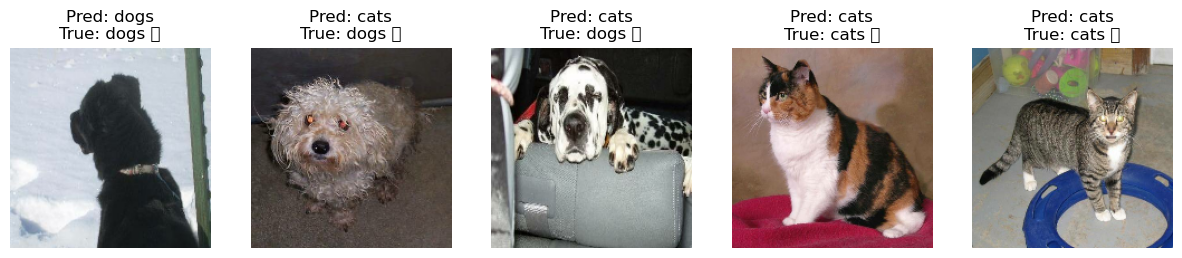

In [11]:
def display_predictions(model, dataset, class_names, num_images=5):
    # Get one batch from the dataset
    images, labels = next(iter(dataset.take(1)))
    
    # Generate predictions
    predictions = model.predict(images)
    
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = images[i].numpy().astype("uint8")
        
        # Convert label tensor to integer if needed
        true_label = class_names[int(labels[i].numpy())]
        predicted_label = class_names[int(predictions[i] > 0.5)]
        
        correct = "✅" if true_label == predicted_label else "❌"
        
        plt.imshow(img)
        plt.title(f"Pred: {predicted_label}\nTrue: {true_label} {correct}")
        plt.axis("off")
    
    plt.show()

# Display predictions (using the validation dataset, for example)
display_predictions(model, val_ds, class_names)
